# Lab13: GAN

Implement the Improved WGAN. Train the Improved WGAN on CelebA dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
import glob

from tqdm import trange

In [2]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [3]:
SAMPLE_COL = 12
SAMPLE_ROW = 12
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 1000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUFFER_SIZE = 65536

# default values
LEARNING_RATE = 0.0001
BETA1 = 0
BETA2 = 0.9
LAMBDA = 10
W_EPOCH = 100

IMG_DIR = './images/'

In [4]:
def load_image(img_path):
    # img_path = tf.strings.as_string(img_path)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=IMG_C)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32)
    img = img / 255. # # Normalizing the images to the range of [0., 1.]
    return img

img_name_train = sorted(glob.glob('./img_align_celeba_png/*.png'))
dataset_train = tf.data.Dataset.from_tensor_slices(img_name_train)\
                               .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .shuffle(BUFFER_SIZE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

len(img_name_train)

202599

In [5]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4

    # return Generator and Discriminator
    return keras.Sequential([  # Generator
        keras.layers.Dense(units=1024, input_shape=(z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units=zh*zw*256),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape=(zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=5,
            strides=2,
            padding='SAME'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters=xc,
            kernel_size=5,
            strides=2,
            padding='SAME',
            activation=keras.activations.sigmoid
        ),
    ]), keras.Sequential([  # Discriminator
        keras.layers.Conv2D(
            filters=32,
            kernel_size=5,
            strides=(2, 2),
            padding='SAME',
            input_shape=img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters=128,
            kernel_size=5,
            strides=(2, 2),
            padding='SAME'
        ),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units=1024),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units=1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [6]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(LEARNING_RATE, BETA1, BETA2)
optimizer_d = keras.optimizers.Adam(LEARNING_RATE, BETA1, BETA2)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ) # latent variable z ~ p(z)

    with tf.GradientTape() as tpg:
        c0 = WG(z, training=True) # fake data

        z1 = WD(c1, training=True) # D_real
        z0 = WD(c0, training=True) # D_fake

        ld = tf.reduce_mean(z0)
        lg = -ld

        eps = tf.random.uniform([BATCH_SIZE, 1, 1, 1])
        
        x_hat = eps * c1 + (1 - eps) * c0
        
        slopes = tf.gradients(WD(x_hat, training=True), x_hat)[0]
        
        l2_norm = tf.sqrt(tf.reduce_sum(slopes ** 2, axis=[1, 2, 3]))
        
        gradient_penalty = (l2_norm - 1.) ** 2

        ld = tf.reduce_mean(z0 - z1 + LAMBDA * gradient_penalty)

    gradient_g = tpg.gradient(lg, WG.trainable_variables)
    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))

    return lg, ld


@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = WG(z, training=True)

        z1 = WD(c1, training=True)
        z0 = WD(c0, training=True)

        ld = tf.reduce_mean(z0)
        lg = -ld

        eps = tf.random.uniform([BATCH_SIZE, 1, 1, 1])
        x_hat = eps * c1 + (1 - eps) * c0
        slopes = tf.gradients(WD(x_hat, training=True), x_hat)[0]
        l2_norm = tf.sqrt(tf.reduce_sum(slopes ** 2, axis=[1, 2, 3]))
        gradient_penalty = (l2_norm - 1.) ** 2

        ld = tf.reduce_mean(z0 - z1 + LAMBDA * gradient_penalty)

    gradient_d = tpd.gradient(ld, WD.trainable_variables)
    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))

    return lg, ld

In [7]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

 24%|██▍       | 24/100 [5:12:57<17:09:31, 812.78s/epoch, loss of g=-31.7, loss of d=-2.14]

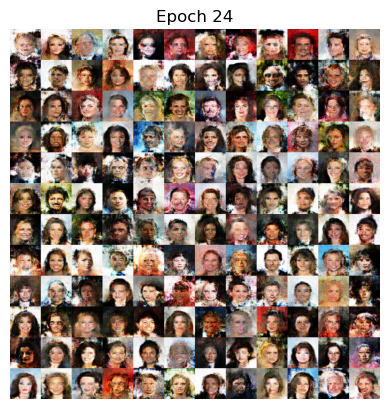

 49%|████▉     | 49/100 [10:15:08<9:31:39, 672.54s/epoch, loss of g=-26.7, loss of d=-2.03]

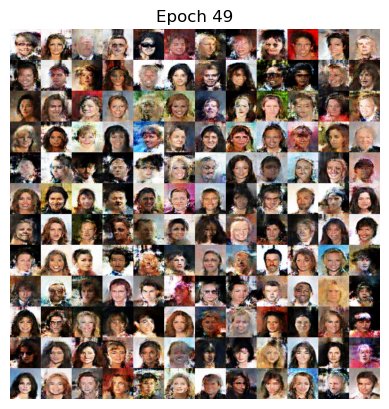

 74%|███████▍  | 74/100 [14:56:33<4:51:52, 673.57s/epoch, loss of g=-19.6, loss of d=-1.95]

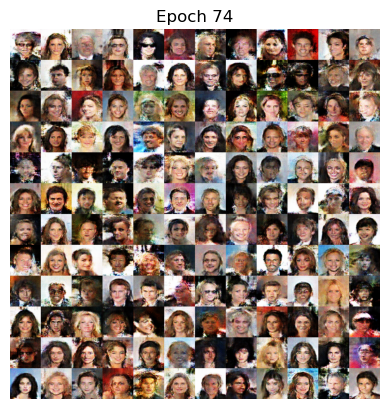

 99%|█████████▉| 99/100 [19:49:10<12:45, 765.47s/epoch, loss of g=-13.8, loss of d=-1.92]  

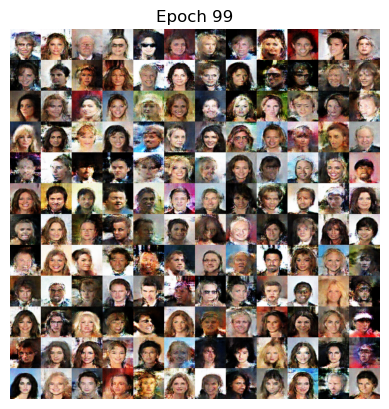

100%|██████████| 100/100 [19:49:10<00:00, 713.51s/epoch, loss of g=-13.8, loss of d=-1.92]


In [8]:
wlg = [None] * W_EPOCH  # record loss of g for each epoch
wld = [None] * W_EPOCH  # record loss of d for each epoch
wsp = [None] * W_EPOCH  # record sample images for each epoch

ctr = 0
rsTrain = float(BATCH_SIZE) / float(len(img_name_train))

pbar = trange(W_EPOCH, unit='epoch')
for ep in pbar:
    lgt = 0.0
    ldt = 0.0
    for c1 in dataset_train:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic: 
            ctr = 0

    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    pbar.set_postfix({'loss of g': lgt * rsTrain, 'loss of d': ldt * rsTrain})

    out = WG(s, training=False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        f'{IMG_DIR}WGAN_{ep:04d}.png'
    )
    wsp[ep] = img
    if (ep + 1) % 25 == 0:
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Epoch {ep:d}')
        plt.show()

In [9]:
utMakeGif(np.array(wsp), "./images/wgan.gif", duration = 2)

MoviePy - Building file ./images/wgan.gif with imageio.


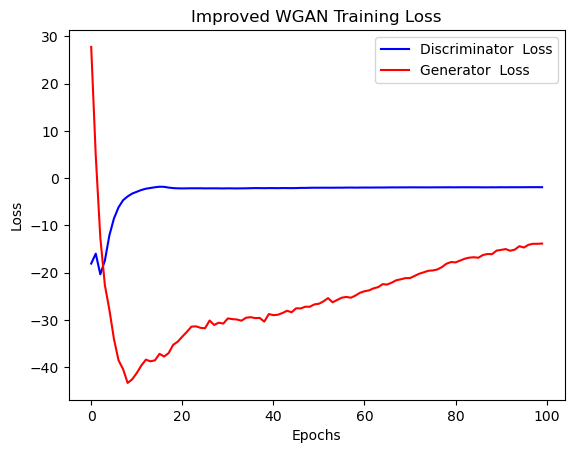

In [10]:
plt.plot(range(W_EPOCH), wld, color='blue', label='Discriminator  Loss')
plt.plot(range(W_EPOCH), wlg, color='red', label='Generator  Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Improved WGAN Training Loss')
plt.show()

## Report

根據[Improved WGAN](https://arxiv.org/pdf/1704.00028.pdf)，omit critic的batch normalization，且optimizer的參數依照paper使用Adam並設定LEARNING_RATE=0.0001, BETA1=0, BETA2=0.9，gradient_penalty也是按照Algorithm1進行計算。生成出來的圖片，大部分人像的輪廓都還算正常，但有少數幾張，整個人臉被毀容了，很像鬼，且全部圖片我覺得都有些模糊，畫質感覺很差，以上原因可能是我train的epoch數(=100)不夠多。